# PRODUCT PROPENSITY - PROD - Redshift - ALL NHL Data
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* July 14, 2022

## Hypothesis
This notebook will test the Product Propensity model features and the goal is to check how the accuracy and scores look when we train the model only with Canucks data compared to all NHL data.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [108]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import psycopg2
from shared_utilities import helpers
from pycaret.classification import *

In [109]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

KKRX-WHXK
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [110]:
teams = [{'lkupclientid': 7, 'clientcode': 'canucks', 'stlrDBName': 'stlrcanucks'},
         {'lkupclientid': 33, 'clientcode': 'vgk', 'stlrDBName': 'stlrvgk'},
         {'lkupclientid': 36, 'clientcode': 'flames', 'stlrDBName': 'stlrflames'},
         {'lkupclientid': 55, 'clientcode': 'coyotes', 'stlrDBName': 'stlrcoyotes'},
         {'lkupclientid': 93, 'clientcode': 'nhlpanthers', 'stlrDBName': 'stlrnhlpanthers'}]

all_data = []
for team in teams:
    conn = helpers.get_redshift_connection('prod-app', team['stlrDBName'])
    
    # call the stored proc to get data for the product propensity model
    cur = conn.cursor()
    cur.execute(f"CALL {team['stlrDBName']}.ds.getproductpropensitymodeldata({team['lkupclientid']},2010, 2022, 'temp_cursor')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn.cursor('temp_cursor')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df = pd.DataFrame(data=data, columns=cols)
    all_data.append(df)
    
    conn.commit()

    

In [111]:
dfObj = pd.DataFrame(columns=['lkupclientid',
    'clientcode',
    'dimcustomermasterid', 
    'distance',
    'seasonyear',
    'events_prior',
    'attended_prior',
    'events_last',
    'attended_last',
    'tenure',
    'atp_last',
    'product_current',
    'product_last'])

In [112]:
for data in all_data:
    dfObj= dfObj.append(data)
dfObj.head()

,lkupclientid,clientcode,dimcustomermasterid,distance,seasonyear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last
0,7,CANUCKS,3,748.34,2018,1,1,1,1,0,119.75,None,Individual
1,7,CANUCKS,3,748.34,2019,1,1,0,0,1,0.0,None,None
2,7,CANUCKS,3,748.34,2021,1,1,0,0,3,0.0,None,None
3,7,CANUCKS,3,748.34,2022,1,1,0,0,4,0.0,None,None
4,7,CANUCKS,4,2.96,2022,1,1,1,1,0,115.34,None,None


In [113]:
dfObj['clientcode'].unique()

array(['CANUCKS', 'VGK', 'FLAMES', 'COYOTES', 'NHLPANTHERS'], dtype=object)

In [114]:
# choose the features for the stellar base retention model
features = [
    "lkupclientid",
    "clientcode",
    "dimcustomermasterid", 
    "distance",
    "seasonyear",
    "events_prior",
    "attended_prior",
    "events_last",
    "attended_last",
    "tenure",
    "atp_last",
    "product_current",
    "product_last"
]

# copy your main dataframe
df_dataset = dfObj

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["seasonyear"] = pd.to_numeric(df_dataset["seasonyear"])
df_dataset = df_dataset.loc[df_dataset["seasonyear"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2206778, 13)
Unseen Data For Predictions: (46171, 13)



In [115]:
setup(
    data= df_train, 
    target="product_current", 
    train_size = 0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=[
        "lkupclientid",
        "clientcode",
        "dimcustomermasterid",
        "seasonyear"
    ],
    numeric_features=[
        "distance",
    "events_prior",
    "attended_prior",
    "events_last",
    "attended_last",
    "tenure",
    "atp_last"
    ]
);

In [116]:
model_matrix = compare_models(
    fold=10,
    include=["rf"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9347,0.8055,0.3296,0.9091,0.9199,0.4542,0.4730,116.9840


In [117]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9347,0.8067,0.3373,0.9092,0.9200,0.4562,0.4744
1,0.9353,0.8048,0.3302,0.9099,0.9205,0.4591,0.4781
2,0.9351,0.8050,0.3362,0.9097,0.9202,0.4571,0.4762
3,0.9343,0.8024,0.3237,0.9081,0.9192,0.4497,0.4688
4,0.9335,0.8053,0.3289,0.9082,0.9190,0.4481,0.4652
5,0.9349,0.8070,0.3298,0.9092,0.9200,0.4544,0.4738
6,0.9345,0.8039,0.3276,0.9089,0.9197,0.4520,0.4709
7,0.9347,0.8034,0.3310,0.9090,0.9198,0.4533,0.4723
8,0.9349,0.8088,0.3279,0.9094,0.9201,0.4565,0.4751
9,0.9350,0.8077,0.3240,0.9094,0.9201,0.4556,0.4751


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [118]:
df_inference_year = dfObj.loc[dfObj["seasonyear"] >= 2022]
df_inference = df_inference_year.loc[df_inference_year["clientcode"] == 'CANUCKS']
df_inference = df_inference.fillna(0)
df_inference.shape

(390563, 13)

In [119]:
df_inference["clientcode"].unique()

array(['CANUCKS'], dtype=object)

In [120]:
df_inference["seasonyear"].unique()

array([2022])

In [121]:
new_predictions = predict_model(final_model, data=df_inference)
new_predictions.head()

,lkupclientid,clientcode,dimcustomermasterid,distance,seasonyear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last,Label,Score
3,7,CANUCKS,3,748.34,2022,1,1,0,0,4,0.00,None,None,None,0.9610
4,7,CANUCKS,4,2.96,2022,1,1,1,1,0,115.34,None,None,None,0.9700
6,7,CANUCKS,6,251.56,2022,1,0,0,0,2,0.00,None,None,None,0.9897
11,7,CANUCKS,7,5.63,2022,1,1,0,0,5,0.00,None,None,None,0.9506
13,7,CANUCKS,8,251.56,2022,3,3,0,0,2,0.00,None,None,None,0.9671


In [122]:
new_predictions["Label"].value_counts()

None                 383050
Individual             2874
Full Season            2698
Quarter                 948
Half Season             505
Groups                  311
Group                   111
Partial Season           26
Mini Pack                16
Flex Plan                12
Mini Plan                 5
Partial                   4
Premier/Core Plan         3
Name: Label, dtype: int64

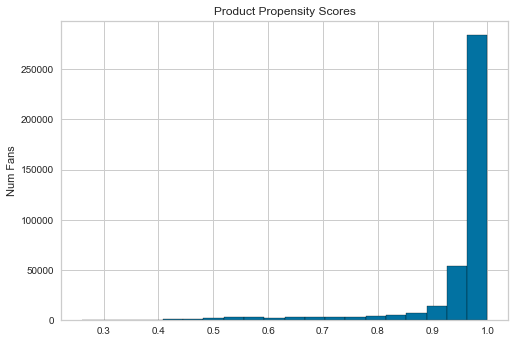

In [123]:
plt.hist(new_predictions["Score"], bins=20, edgecolor='black')
plt.title("Product Propensity Scores")
plt.ylabel("Num Fans")
plt.show()

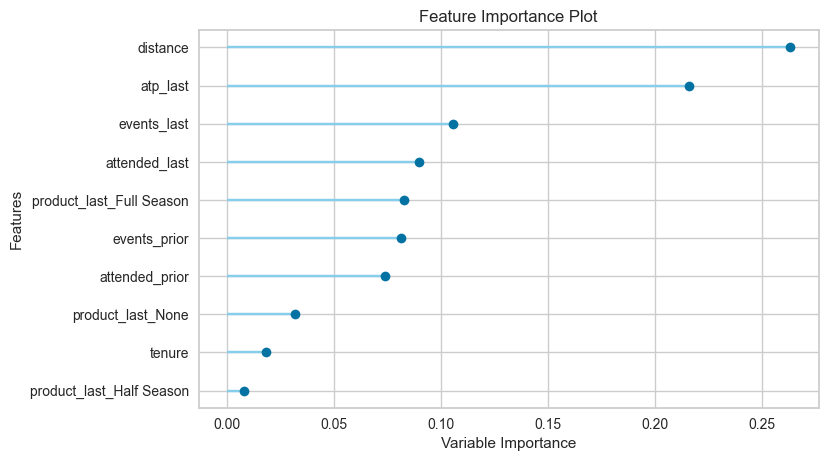

In [124]:
plot_model(final_model, plot='feature')

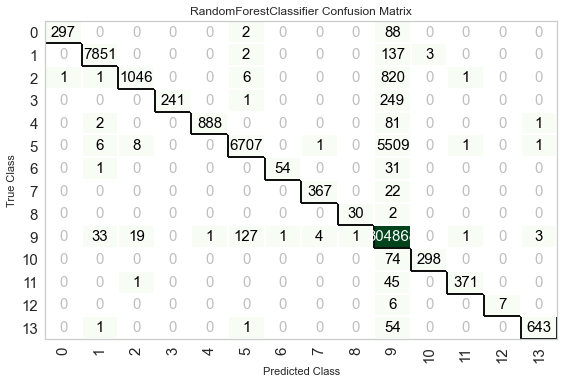

In [125]:
plot_model(final_model, plot='confusion_matrix')

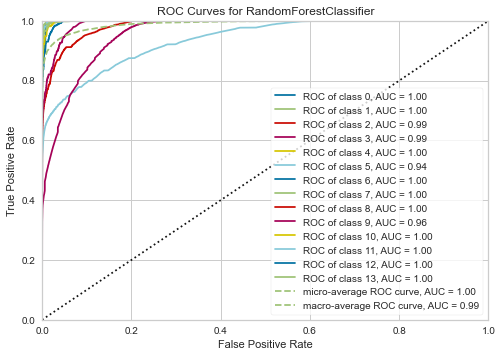

In [126]:
plot_model(final_model, plot='auc')

In [127]:
report = ProfileReport(new_predictions)
report.to_file("NHL_data_PP_predictions.html")

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [128]:
report2 = ProfileReport(df)
report2.to_file("NHL_data_PP_df.html")

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Observations for using NHL data

1. How accurate was this model? 
* The accuracy is 93% (1% more than using canucks data)

2. How does the prediction looks for each package?
* None:                 382891
* Individual:             2904
* Full Season:            2801
* Quarter:                 963
* Half Season:             510
* Groups:                  317
* Group:                   110
* Partial Season:           25
* Mini Pack:                15
* Flex Plan:                12
* Partial:                   7
* Mini Plan:                 4
* Premier/Core Plan:         3
* Mini-Plan:                 1

3. What were the most important features in making a correct prediction?
*  distance, atp_last, product_last_full season are top 3 important features.


### Done